# Modeling
- Training and testing

In [1]:
import sys
print("Python version")
print (sys.version)

Python version
3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import sklearn
import numpy as np
from numpy import sqrt
from numpy import argmax
from scipy import stats
import os
import pickle
import itertools
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import manifold
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, SparsePCA, sparse_encode, FactorAnalysis, KernelPCA
import time

In [3]:
pd.set_option('display.max_columns', None)

## Load cleaned dataset

In [4]:
train_df = pd.read_csv('data/training_cleaned_v5.csv', index_col='ID')

## Make train/val/test sets

In [5]:
X = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

In [6]:
# put 25% examples in val/test set
# Set random seed to ensure reproducible runs
RSEED = 7

X_train, X_temp, y_train, y_temp = train_test_split(X, 
                                                    y, 
                                                    stratify = y,
                                                    test_size = 0.25, 
                                                    random_state = RSEED)

X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                y_temp, 
                                                stratify = y_temp,
                                                test_size = 0.5, 
                                                random_state = RSEED)

## Define training, plotting methods

In [7]:
def evaluate_model(predict_train, predict_val, predict_test, probability_train, probability_val, probability_test, y_train, y_val, y_test, 
                   classes=['no_vacc', 'vacc'], normalize=False, title='Classifier', cmap=plt.cm.Oranges):
    
    """Compare machine learning model to baseline performance.
    - Computes statistics and shows ROC curve.
    - Plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`."""
    
    print(classification_report(y_test, predict_test, target_names=classes))
    
    #plot ROC
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['auroc'] = 0.5

    train_results = {}
    train_results['recall'] = recall_score(y_train, predict_train)
    train_results['precision'] = precision_score(y_train, predict_train)
    train_results['auroc'] = roc_auc_score(y_train, probability_train)
    
    val_results = {}
    val_results['recall'] = recall_score(y_val, predict_val)
    val_results['precision'] = precision_score(y_val, predict_val)
    val_results['auroc'] = roc_auc_score(y_val, probability_val)
    
    test_results = {}
    test_results['recall'] = recall_score(y_test, predict_test)
    test_results['precision'] = precision_score(y_test, predict_test)
    test_results['auroc'] = roc_auc_score(y_test, probability_test)
    
#     for metric in ['recall', 'precision', 'auroc']:
#         print(f'{metric.capitalize():10s}--> Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    fpr_train, tpr_train, _ = roc_curve(y_train, probability_train)
    fpr_val, tpr_val, thresholds_val = roc_curve(y_val, probability_val)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probability_test)
    fpr_base, tpr_base, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    
    # recalculate prediction
    gmeans = sqrt(tpr_val * (1-fpr_val))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    T_val = thresholds_val[ix] #Best Threshold
    #print('thresholds_val', thresholds_val)
    print('T_val:', T_val)
    
    for i in range(len(thresholds_test)):
        if thresholds_test[i] < T_val:
            ix_test = i
            break
#     print('test', ix_test, thresholds_test[ix_test], thresholds_test[ix_test-1])
#     print('Best Threshold=%f, G-Mean=%.3f' % (T_val, gmeans[ix]))
    fig, axs = plt.subplots(1, 2, figsize = (10, 5), gridspec_kw={'width_ratios': [1, 1.2]})
    
    # Plot ROC curves
    axs[0].scatter(fpr_val[ix], tpr_val[ix], marker='o', color='#1E90FF', label='Best in val') # plot best val point
    axs[0].scatter((fpr_test[ix_test]+fpr_test[ix_test-1])/2, (tpr_test[ix_test]+tpr_test[ix_test-1])/2, marker='o', color='r', label='Best in test')# plot best test point
    
    axs[0].plot(fpr_train, tpr_train, '#32CD32', label = 'Train', linestyle='dashed')
    axs[0].plot(fpr_val, tpr_val, '#1E90FF', label = 'validation')
    axs[0].plot(fpr_test, tpr_test, 'r', label = 'Test')
    axs[0].plot(fpr_base, tpr_base, '#8B4513', label = 'Baseline')
    
    axs[0].legend(prop={'size': 10}, loc = (0.60, 0.05))
    #axs[0].legend(prop={'size': 10}, loc='lower right')
    axs[0].set_xlabel('False Positive Rate', size = 16)
    axs[0].set_ylabel('True Positive Rate', size = 16)
    axs[0].set_title('ROC curves')
    axs[0].tick_params(axis='both', which='major', labelsize=14)
    
    Train_AUROC = roc_auc_score(y_train, probability_train)
    Test_AUROC = roc_auc_score(y_test, probability_test)
    
    axs[0].text(0.13,0.6, f'Train AUROC: {Train_AUROC:.4f}\nTest AUROC: {Test_AUROC:.4f}', fontsize=12 )
    
    print(f'Train AUROC: {Train_AUROC:.4f}')
    print(f'Test AUROC: {Test_AUROC:.4f}')
    
    # Plot confusion matrix heatmap
    predict_test = [1 if x > T_val else 0 for x in probability_test]
    cm = confusion_matrix(y_test, predict_test, labels=[0,1]) # counts
    cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # %

    im = axs[1].imshow(cm2, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    axs[1].set_title('Confusion matrix (Test)')
    
    # Create colorbar
    cbar = axs[1].figure.colorbar(im, ax=axs[1])
    cbar.ax.tick_params(labelsize=12) 
    cbar.ax.set_ylabel('Fraction of true classes')
    
    # We want to show all ticks...
    axs[1].set_xticks(np.arange(len(classes)))
    axs[1].set_yticks(np.arange(len(classes)))
    tick_marks = np.arange(len(classes))
    axs[1].set_xticklabels(classes)
    axs[1].set_yticklabels(classes,rotation=90, va='center')
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    
    thresh = cm2.max()*0.7
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm2[i, j]:.2f}\n({cm[i, j]:,d})',
                 fontsize = 14,
                 ha="center",
                 va='center',
                 color="white" if cm2[i, j] > thresh else "black")
    
    axs[1].set_ylabel('True label', size = 16)
    axs[1].set_xlabel('Predicted label', size = 16)
    
    fig.suptitle(title, fontsize="xx-large")
    plt.tight_layout()
    plt.savefig(f"best_models/Model_performance_{title.replace(' ', '_')}.pdf")
    return T_val

In [8]:
def benchmark_classifiers(clf, model_name, X_train, X_val, X_test, y_train, y_val, y_test):
    print(f'----- Classification Report {model_name} -----')
    clf.fit(X_train, y_train)
    probability_train = clf.predict_proba(X_train)[:, 1]
    probability_val = clf.predict_proba(X_val)[:, 1]
    probability_test = clf.predict_proba(X_test)[:, 1]
    predict_train = clf.predict(X_train)
    predict_val = clf.predict(X_val)
    predict_test = clf.predict(X_test)
    T_val = evaluate_model(predict_train, predict_val, predict_test, probability_train, probability_val, probability_test, y_train, y_val, y_test, normalize=True, title=model_name)
    return T_val

## Training

In [9]:
clf_list = {'Random Forest 300x15 v5': RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='balanced', max_depth=15, random_state=RSEED),
            'Random Forest 100x10 v5': RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', max_depth=10, random_state=RSEED),
            'Random Forest 200x15 v5': RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced', max_depth=15, random_state=RSEED),
            'Gradient Boost 50x8 v5' : GradientBoostingClassifier(n_estimators=50, max_depth=8, random_state=RSEED, verbose=1),
            'Gradient Boost 100x8 v5': GradientBoostingClassifier(n_estimators=100, max_depth=8, random_state=RSEED, verbose=1),
            'Gradient Boost 200x8 v5': GradientBoostingClassifier(n_estimators=200, max_depth=8, random_state=RSEED, verbose=1),
#             'Gradient Boost 500x8 v5': GradientBoostingClassifier(n_estimators=500, max_depth=8, random_state=RSEED, verbose=1),
#             'Random Forest 500x15 v5': RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='balanced', max_depth=15, random_state=RSEED),
#             'Decision Tree v5': DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=RSEED),
#             'Neural Net 100 v5': MLPClassifier(max_iter=1000),
#             'Neural Net 100*50 v5': MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000),
#             'Neural Net 100*100 v5': MLPClassifier(hidden_layer_sizes=(100,100), max_iter=60),
#             'Neural Net 100*100 v5': MLPClassifier(hidden_layer_sizes=(100,100), max_iter=60),  
#             'Neural Net 100*100*100 v5': MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=60),  
#             'SVC_linear v5': SVC(kernel="linear", C=0.025, class_weight='balanced', random_state=RSEED),
#             'SVC_RBF v5': SVC(kernel="rbf", gamma=2, C=1, class_weight='balanced', random_state=RSEED),
#             'GaussianProcess v5': GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=-1, random_state=RSEED),
#             'Logistic Regression v5': LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=RSEED),
#             'Ada Boost 80 v5': AdaBoostClassifier(n_estimators=80, random_state=RSEED),
#             'KNeighbors v5': KNeighborsClassifier(5, n_jobs=-1, leaf_size=10),
           }

----- Classification Report Random Forest 300x15 v5 -----
              precision    recall  f1-score   support

     no_vacc       0.88      0.70      0.78    100674
        vacc       0.27      0.53      0.36     21182

    accuracy                           0.67    121856
   macro avg       0.57      0.61      0.57    121856
weighted avg       0.77      0.67      0.70    121856

T_val: 0.4746636676032516
Train AUROC: 0.8559
Test AUROC: 0.6676

----- Classification Report Random Forest 100x10 v5 -----
              precision    recall  f1-score   support

     no_vacc       0.89      0.57      0.70    100674
        vacc       0.25      0.68      0.36     21182

    accuracy                           0.59    121856
   macro avg       0.57      0.62      0.53    121856
weighted avg       0.78      0.59      0.64    121856

T_val: 0.5096088046663495
Train AUROC: 0.6956
Test AUROC: 0.6668

----- Classification Report Random Forest 200x15 v5 -----
              precision    recall  f1-sc

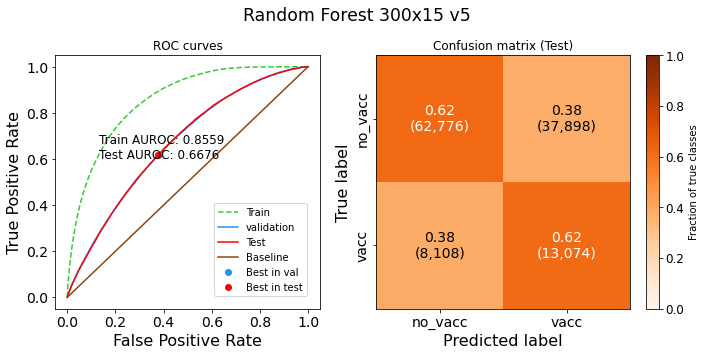

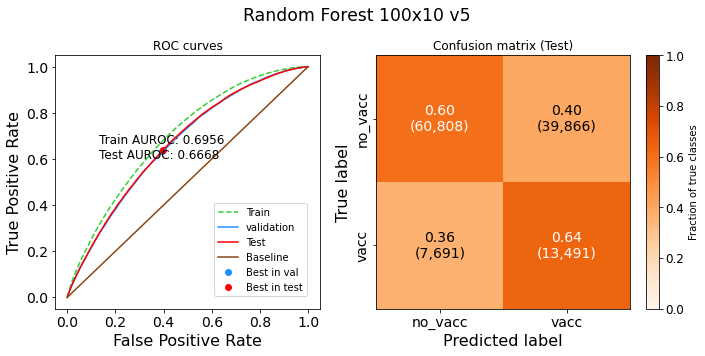

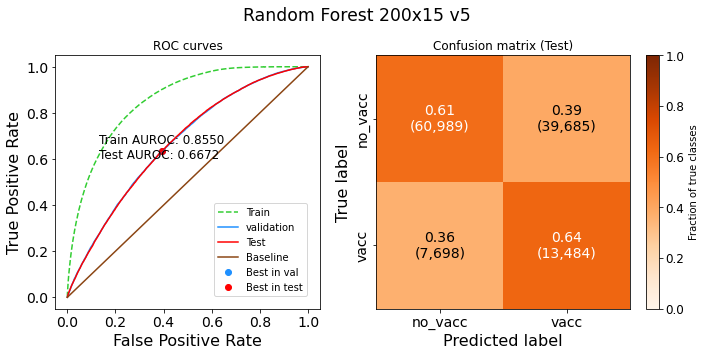

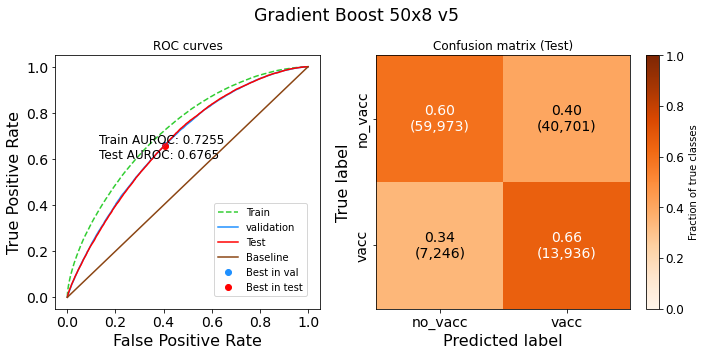

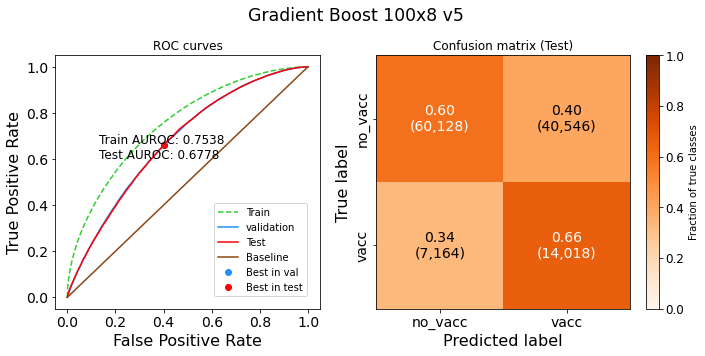

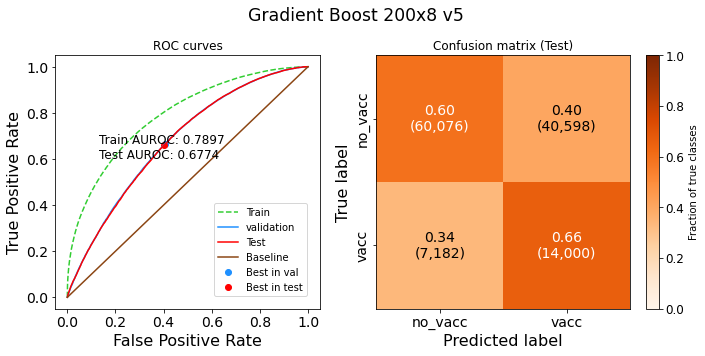

In [10]:
clf_trained = {}
for clf_name in clf_list:
    clf = clf_list[clf_name]
    T_val = benchmark_classifiers(clf, clf_name, X_train, X_val, X_test, y_train, y_val, y_test)
    clf_trained[clf_name] = (clf, T_val)
    with open(f'best_models/{clf_name}_model.pk','wb') as ofile:
        pickle.dump((clf, T_val), ofile)
    print()

## Check feature importance

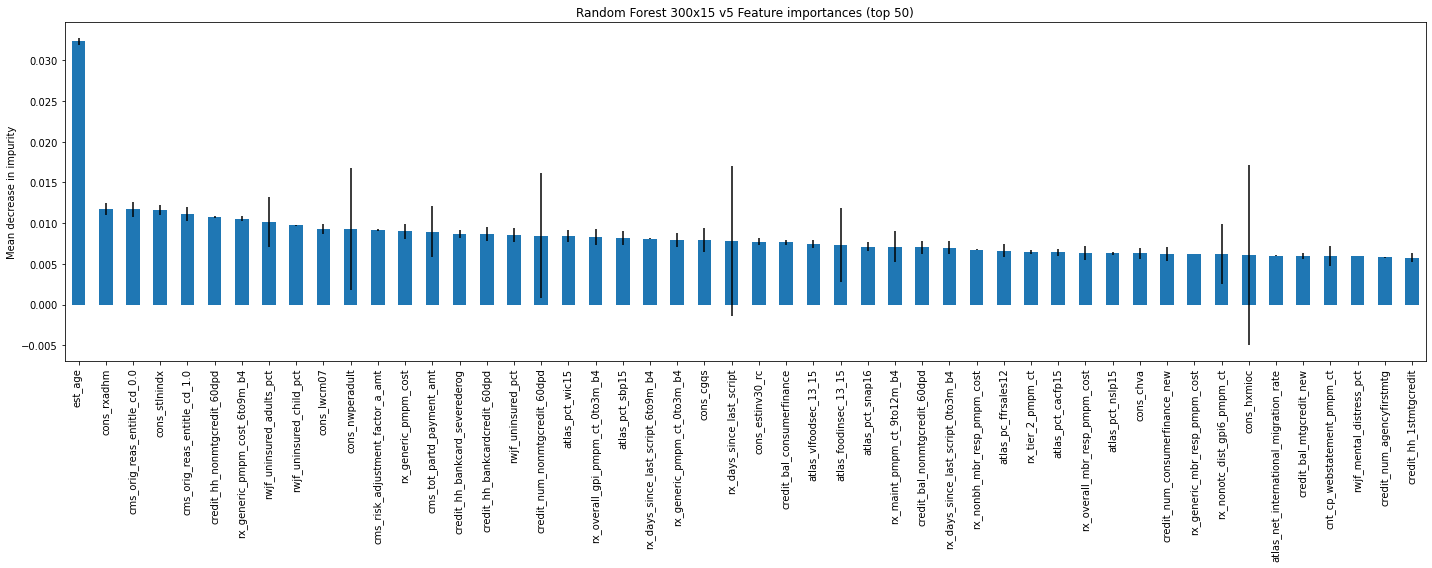

In [14]:
name = 'Random Forest 300x15 v5'

importances = clf_list[name].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_list[name].estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)[:50]
fig, ax = plt.subplots(figsize=(20,8))
forest_importances.plot.bar(yerr=std[:50], ax=ax)
ax.set_title(f"{name} Feature importances (top 50)")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig(f"plots/Top_50_features_{name.replace(' ', '_')}.pdf")

In [13]:
forest_importances

est_age                                   0.032339
cons_rxadhm                               0.011790
cms_orig_reas_entitle_cd_0.0              0.011716
cons_stlnindx                             0.011618
cms_orig_reas_entitle_cd_1.0              0.011129
credit_hh_nonmtgcredit_60dpd              0.010703
rx_generic_pmpm_cost_6to9m_b4             0.010533
rwjf_uninsured_adults_pct                 0.010125
rwjf_uninsured_child_pct                  0.009756
cons_lwcm07                               0.009260
cons_nwperadult                           0.009249
cms_risk_adjustment_factor_a_amt          0.009162
rx_generic_pmpm_cost                      0.009021
cms_tot_partd_payment_amt                 0.008977
credit_hh_bankcard_severederog            0.008680
credit_hh_bankcardcredit_60dpd            0.008651
rwjf_uninsured_pct                        0.008535
credit_num_nonmtgcredit_60dpd             0.008478
atlas_pct_wic15                           0.008445
rx_overall_gpi_pmpm_ct_0to3m_b4